# Method 6 - Best Ideas

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Add Expected Returns from Market Relative Weight per Shumway, Szefler, Yuan 2009

%store -r mkt_exp_ret

valid_data = valid_data.merge(mkt_exp_ret, on=['datadate', 'institution_id', 'fsym_id'], how='left')

# Calculate CSP Weight per Market Tilt

valid_data['adj_target'] = valid_data['expected_return']

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data.groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] == 1].copy()

# Weight the best ideas equally

best_ideas['target'] = 1 / best_ideas.groupby('datadate')['institution_id'].transform('count')

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

rf = bi.get_risk_free_rate()
monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

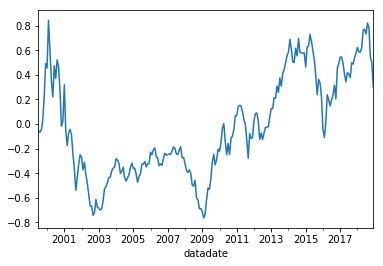

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.491777
2000-12-31   -0.314572
2001-12-31   -0.267560
2002-12-31   -0.570093
2003-12-31    1.014303
2004-12-31    0.052923
2005-12-31   -0.006391
2006-12-31    0.100529
2007-12-31   -0.024657
2008-12-31   -0.570861
2009-12-31    1.544188
2010-12-31    0.341096
2011-12-31   -0.166839
2012-12-31    0.193449
2013-12-31    0.467865
2014-12-31    0.013655
2015-12-31   -0.230927
2016-12-31    0.229924
2017-12-31    0.057091
2018-12-31   -0.174801
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.829
Method:                 Least Squares   F-statistic:                     282.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.61e-87
Time:                        14:51:39   Log-Likelihood:                 393.46
No. Observations:                 234   AIC:                            -776.9
Df Residuals:                     229   BIC:                            -759.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0041      0.003      1.333      0.184      -0.002       0.010
mktrf          1.3636      0.085     16.062      0.000       1.196       1.531
me             0.6472      0.099      6.553      0.000       0.453       0.842
ia            -0.0514      0.150     -0.342      0.732      -0.347       0.244
roe           -1.3650      0.128    -10.625      0.000      -1.618      -1.112
==============================================================================
Omnibus:                      144.591   Durbin-Watson:                   2.112
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1939.321
Skew:                           2.138   Prob(JB):                         0.00
Kurtosis:                      16.439   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.829
Method:                 Least Squares   F-statistic:                     118.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.81e-54
Time:                        14:51:39   Log-Likelihood:                 393.46
No. Observations:                 234   AIC:                            -776.9
Df Residuals:                     229   BIC:                            -759.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0041      0.003      1.298      0.194      -0.002       0.010
mktrf          1.3636      0.160      8.504      0.000       1.049       1.678
me             0.6472      0.109      5.950      0.000       0.434       0.860
ia            -0.0514      0.206     -0.249      0.803      -0.456       0.353
roe           -1.3650      0.213     -6.402      0.000      -1.783      -0.947
==============================================================================
Omnibus:                      144.591   Durbin-Watson:                   2.112
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1939.321
Skew:                           2.138   Prob(JB):                         0.00
Kurtosis:                      16.439   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.829
Method:                 Least Squares   F-statistic:                     129.8
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.09e-57
Time:                        14:51:39   Log-Likelihood:                 393.46
No. Observations:                 234   AIC:                            -776.9
Df Residuals:                     229   BIC:                            -759.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0041      0.003      1.213      0.225      -0.003       0.011
mktrf          1.3636      0.161      8.485      0.000       1.049       1.679
me             0.6472      0.124      5.216      0.000       0.404       0.890
ia            -0.0514      0.197     -0.261      0.794      -0.438       0.335
roe           -1.3650      0.228     -5.991      0.000      -1.812      -0.918
==============================================================================
Omnibus:                      144.591   Durbin-Watson:                   2.112
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1939.321
Skew:                           2.138   Prob(JB):                         0.00
Kurtosis:                      16.439   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.810
Model:                            OLS   Adj. R-squared:                  0.806
Method:                 Least Squares   F-statistic:                     194.8
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.31e-80
Time:                        14:51:39   Log-Likelihood:                 379.60
No. Observations:                 234   AIC:                            -747.2
Df Residuals:                     228   BIC:                            -726.5
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0030      0.003      0.887      0.376      -0.004       0.010
mktrf          1.5061      0.090     16.650      0.000       1.328       1.684
smb            0.6909      0.119      5.789      0.000       0.456       0.926
hml            0.1877      0.141      1.334      0.184      -0.090       0.465
rmw           -1.2169      0.159     -7.648      0.000      -1.530      -0.903
cma        -3.008e-05      0.202     -0.000      1.000      -0.399       0.399
==============================================================================
Omnibus:                      138.031   Durbin-Watson:                   1.989
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1110.883
Skew:                           2.219   Prob(JB):                    5.95e-242
Kurtosis:                      12.707   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.810
Model:                            OLS   Adj. R-squared:                  0.806
Method:                 Least Squares   F-statistic:                     112.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.00e-59
Time:                        14:51:39   Log-Likelihood:                 379.60
No. Observations:                 234   AIC:                            -747.2
Df Residuals:                     228   BIC:                            -726.5
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0030      0.003      0.863      0.388      -0.004       0.010
mktrf          1.5061      0.107     14.073      0.000       1.296       1.716
smb            0.6909      0.123      5.626      0.000       0.450       0.932
hml            0.1877      0.240      0.782      0.434      -0.282       0.658
rmw           -1.2169      0.218     -5.571      0.000      -1.645      -0.789
cma        -3.008e-05      0.312  -9.63e-05      1.000      -0.612       0.612
==============================================================================
Omnibus:                      138.031   Durbin-Watson:                   1.989
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1110.883
Skew:                           2.219   Prob(JB):                    5.95e-242
Kurtosis:                      12.707   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.810
Model:                            OLS   Adj. R-squared:                  0.806
Method:                 Least Squares   F-statistic:                     125.8
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.61e-63
Time:                        14:51:39   Log-Likelihood:                 379.60
No. Observations:                 234   AIC:                            -747.2
Df Residuals:                     228   BIC:                            -726.5
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0030      0.004      0.790      0.430      -0.004       0.010
mktrf          1.5061      0.095     15.868      0.000       1.320       1.692
smb            0.6909      0.121      5.727      0.000       0.454       0.927
hml            0.1877      0.195      0.962      0.336      -0.195       0.570
rmw           -1.2169      0.232     -5.239      0.000      -1.672      -0.762
cma        -3.008e-05      0.293     -0.000      1.000      -0.574       0.574
==============================================================================
Omnibus:                      138.031   Durbin-Watson:                   1.989
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1110.883
Skew:                           2.219   Prob(JB):                    5.95e-242
Kurtosis:                      12.707   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.815
Model:                            OLS   Adj. R-squared:                  0.812
Method:                 Least Squares   F-statistic:                     252.8
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           9.22e-83
Time:                        14:51:39   Log-Likelihood:                 382.74
No. Observations:                 234   AIC:                            -755.5
Df Residuals:                     229   BIC:                            -738.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0003      0.003     -0.079      0.937      -0.007       0.006
mktrf          1.5610      0.082     19.076      0.000       1.400       1.722
smb            1.2732      0.102     12.464      0.000       1.072       1.474
hml           -0.1317      0.101     -1.298      0.196      -0.332       0.068
umd           -0.5265      0.067     -7.908      0.000      -0.658      -0.395
==============================================================================
Omnibus:                      116.339   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1008.727
Skew:                           1.739   Prob(JB):                    9.07e-220
Kurtosis:                      12.558   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.815
Model:                            OLS   Adj. R-squared:                  0.812
Method:                 Least Squares   F-statistic:                     132.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.65e-58
Time:                        14:51:39   Log-Likelihood:                 382.74
No. Observations:                 234   AIC:                            -755.5
Df Residuals:                     229   BIC:                            -738.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0003      0.003     -0.085      0.932      -0.006       0.006
mktrf          1.5610      0.128     12.170      0.000       1.310       1.812
smb            1.2732      0.099     12.817      0.000       1.078       1.468
hml           -0.1317      0.160     -0.821      0.412      -0.446       0.183
umd           -0.5265      0.106     -4.946      0.000      -0.735      -0.318
==============================================================================
Omnibus:                      116.339   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1008.727
Skew:                           1.739   Prob(JB):                    9.07e-220
Kurtosis:                      12.558   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.815
Model:                            OLS   Adj. R-squared:                  0.812
Method:                 Least Squares   F-statistic:                     128.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.86e-57
Time:                        14:51:39   Log-Likelihood:                 382.74
No. Observations:                 234   AIC:                            -755.5
Df Residuals:                     229   BIC:                            -738.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0003      0.003     -0.083      0.934      -0.006       0.006
mktrf          1.5610      0.123     12.698      0.000       1.320       1.802
smb            1.2732      0.096     13.302      0.000       1.086       1.461
hml           -0.1317      0.150     -0.880      0.379      -0.425       0.162
umd           -0.5265      0.107     -4.939      0.000      -0.735      -0.318
==============================================================================
Omnibus:                      116.339   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1008.727
Skew:                           1.739   Prob(JB):                    9.07e-220
Kurtosis:                      12.558   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.825
Model:                            OLS   Adj. R-squared:                  0.819
Method:                 Least Squares   F-statistic:                     135.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.27e-42
Time:                        14:51:39   Log-Likelihood:                 181.17
No. Observations:                 120   AIC:                            -352.3
Df Residuals:                     115   BIC:                            -338.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0083      0.005      1.595      0.113      -0.002       0.019
mktrf          1.2628      0.141      8.971      0.000       0.984       1.542
me             0.5485      0.139      3.945      0.000       0.273       0.824
ia            -0.2521      0.218     -1.158      0.249      -0.683       0.179
roe           -1.3909      0.193     -7.217      0.000      -1.773      -1.009
==============================================================================
Omnibus:                       67.874   Durbin-Watson:                   2.145
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              460.637
Skew:                           1.772   Prob(JB):                    9.42e-101
Kurtosis:                      11.920   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.825
Model:                            OLS   Adj. R-squared:                  0.819
Method:                 Least Squares   F-statistic:                     112.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           9.61e-39
Time:                        14:51:39   Log-Likelihood:                 181.17
No. Observations:                 120   AIC:                            -352.3
Df Residuals:                     115   BIC:                            -338.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0083      0.005      1.758      0.079      -0.001       0.018
mktrf          1.2628      0.243      5.201      0.000       0.787       1.739
me             0.5485      0.146      3.762      0.000       0.263       0.834
ia            -0.2521      0.287     -0.878      0.380      -0.815       0.311
roe           -1.3909      0.290     -4.791      0.000      -1.960      -0.822
==============================================================================
Omnibus:                       67.874   Durbin-Watson:                   2.145
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              460.637
Skew:                           1.772   Prob(JB):                    9.42e-101
Kurtosis:                      11.920   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.825
Model:                            OLS   Adj. R-squared:                  0.819
Method:                 Least Squares   F-statistic:                     125.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.13e-41
Time:                        14:51:39   Log-Likelihood:                 181.17
No. Observations:                 120   AIC:                            -352.3
Df Residuals:                     115   BIC:                            -338.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0083      0.005      1.765      0.078      -0.001       0.018
mktrf          1.2628      0.246      5.127      0.000       0.780       1.746
me             0.5485      0.163      3.356      0.001       0.228       0.869
ia            -0.2521      0.264     -0.956      0.339      -0.769       0.265
roe           -1.3909      0.322     -4.314      0.000      -2.023      -0.759
==============================================================================
Omnibus:                       67.874   Durbin-Watson:                   2.145
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              460.637
Skew:                           1.772   Prob(JB):                    9.42e-101
Kurtosis:                      11.920   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.807
Model:                            OLS   Adj. R-squared:                  0.798
Method:                 Least Squares   F-statistic:                     95.21
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.91e-39
Time:                        14:51:39   Log-Likelihood:                 175.10
No. Observations:                 120   AIC:                            -338.2
Df Residuals:                     114   BIC:                            -321.5
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0084      0.006      1.486      0.140      -0.003       0.020
mktrf          1.5819      0.157     10.087      0.000       1.271       1.893
smb            0.6499      0.178      3.659      0.000       0.298       1.002
hml           -0.1115      0.218     -0.512      0.609      -0.543       0.320
rmw           -0.9944      0.257     -3.874      0.000      -1.503      -0.486
cma            0.0475      0.281      0.169      0.866      -0.510       0.605
==============================================================================
Omnibus:                       77.691   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              405.043
Skew:                           2.269   Prob(JB):                     1.11e-88
Kurtosis:                      10.773   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.807
Model:                            OLS   Adj. R-squared:                  0.798
Method:                 Least Squares   F-statistic:                     48.83
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           8.75e-27
Time:                        14:51:39   Log-Likelihood:                 175.10
No. Observations:                 120   AIC:                            -338.2
Df Residuals:                     114   BIC:                            -321.5
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0084      0.005      1.813      0.070      -0.001       0.018
mktrf          1.5819      0.192      8.238      0.000       1.206       1.958
smb            0.6499      0.177      3.662      0.000       0.302       0.998
hml           -0.1115      0.212     -0.526      0.599      -0.527       0.304
rmw           -0.9944      0.291     -3.416      0.001      -1.565      -0.424
cma            0.0475      0.351      0.135      0.892      -0.641       0.736
==============================================================================
Omnibus:                       77.691   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              405.043
Skew:                           2.269   Prob(JB):                     1.11e-88
Kurtosis:                      10.773   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.807
Model:                            OLS   Adj. R-squared:                  0.798
Method:                 Least Squares   F-statistic:                     62.51
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.59e-31
Time:                        14:51:39   Log-Likelihood:                 175.10
No. Observations:                 120   AIC:                            -338.2
Df Residuals:                     114   BIC:                            -321.5
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0084      0.005      1.740      0.082      -0.001       0.018
mktrf          1.5819      0.157     10.079      0.000       1.274       1.890
smb            0.6499      0.168      3.879      0.000       0.322       0.978
hml           -0.1115      0.176     -0.634      0.526      -0.456       0.233
rmw           -0.9944      0.316     -3.144      0.002      -1.614      -0.374
cma            0.0475      0.320      0.149      0.882      -0.579       0.674
==============================================================================
Omnibus:                       77.691   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              405.043
Skew:                           2.269   Prob(JB):                     1.11e-88
Kurtosis:                      10.773   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.830
Model:                            OLS   Adj. R-squared:                  0.824
Method:                 Least Squares   F-statistic:                     140.8
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.40e-43
Time:                        14:51:39   Log-Likelihood:                 182.92
No. Observations:                 120   AIC:                            -355.8
Df Residuals:                     115   BIC:                            -341.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0044      0.005      0.873      0.384      -0.006       0.014
mktrf          1.5744      0.122     12.881      0.000       1.332       1.816
smb            1.2079      0.139      8.680      0.000       0.932       1.484
hml           -0.3796      0.139     -2.724      0.007      -0.656      -0.104
umd           -0.5061      0.086     -5.889      0.000      -0.676      -0.336
==============================================================================
Omnibus:                       67.388   Durbin-Watson:                   2.045
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              431.794
Skew:                           1.781   Prob(JB):                     1.73e-94
Kurtosis:                      11.583   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.830
Model:                            OLS   Adj. R-squared:                  0.824
Method:                 Least Squares   F-statistic:                     140.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.10e-43
Time:                        14:51:39   Log-Likelihood:                 182.92
No. Observations:                 120   AIC:                            -355.8
Df Residuals:                     115   BIC:                            -341.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0044      0.004      1.082      0.279      -0.004       0.012
mktrf          1.5744      0.187      8.425      0.000       1.208       1.941
smb            1.2079      0.121     10.004      0.000       0.971       1.445
hml           -0.3796      0.197     -1.927      0.054      -0.766       0.006
umd           -0.5061      0.112     -4.518      0.000      -0.726      -0.287
==============================================================================
Omnibus:                       67.388   Durbin-Watson:                   2.045
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              431.794
Skew:                           1.781   Prob(JB):                     1.73e-94
Kurtosis:                      11.583   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.830
Model:                            OLS   Adj. R-squared:                  0.824
Method:                 Least Squares   F-statistic:                     165.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           9.80e-47
Time:                        14:51:39   Log-Likelihood:                 182.92
No. Observations:                 120   AIC:                            -355.8
Df Residuals:                     115   BIC:                            -341.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0044      0.004      1.123      0.261      -0.003       0.012
mktrf          1.5744      0.184      8.574      0.000       1.214       1.934
smb            1.2079      0.114     10.606      0.000       0.985       1.431
hml           -0.3796      0.182     -2.088      0.037      -0.736      -0.023
umd           -0.5061      0.116     -4.374      0.000      -0.733      -0.279
==============================================================================
Omnibus:                       67.388   Durbin-Watson:                   2.045
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              431.794
Skew:                           1.781   Prob(JB):                     1.73e-94
Kurtosis:                      11.583   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.863
Model:                            OLS   Adj. R-squared:                  0.858
Method:                 Least Squares   F-statistic:                     171.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.62e-46
Time:                        14:51:39   Log-Likelihood:                 231.01
No. Observations:                 114   AIC:                            -452.0
Df Residuals:                     109   BIC:                            -438.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       8.707e-05      0.003      0.027      0.979      -0.006       0.007
mktrf          1.4516      0.096     15.138      0.000       1.262       1.642
me             0.8019      0.148      5.416      0.000       0.508       1.095
ia             0.2653      0.205      1.292      0.199      -0.142       0.672
roe           -1.4319      0.180     -7.935      0.000      -1.789      -1.074
==============================================================================
Omnibus:                       28.640   Durbin-Watson:                   2.082
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               62.289
Skew:                           0.984   Prob(JB):                     2.98e-14
Kurtosis:                       6.039   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.863
Model:                            OLS   Adj. R-squared:                  0.858
Method:                 Least Squares   F-statistic:                     127.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.38e-40
Time:                        14:51:39   Log-Likelihood:                 231.01
No. Observations:                 114   AIC:                            -452.0
Df Residuals:                     109   BIC:                            -438.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       8.707e-05      0.002      0.035      0.972      -0.005       0.005
mktrf          1.4516      0.119     12.153      0.000       1.218       1.686
me             0.8019      0.196      4.095      0.000       0.418       1.186
ia             0.2653      0.230      1.156      0.248      -0.185       0.715
roe           -1.4319      0.288     -4.964      0.000      -1.997      -0.867
==============================================================================
Omnibus:                       28.640   Durbin-Watson:                   2.082
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               62.289
Skew:                           0.984   Prob(JB):                     2.98e-14
Kurtosis:                       6.039   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.863
Model:                            OLS   Adj. R-squared:                  0.858
Method:                 Least Squares   F-statistic:                     141.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.59e-42
Time:                        14:51:39   Log-Likelihood:                 231.01
No. Observations:                 114   AIC:                            -452.0
Df Residuals:                     109   BIC:                            -438.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       8.707e-05      0.002      0.038      0.970      -0.004       0.005
mktrf          1.4516      0.112     12.912      0.000       1.231       1.672
me             0.8019      0.229      3.502      0.000       0.353       1.251
ia             0.2653      0.253      1.050      0.294      -0.230       0.760
roe           -1.4319      0.295     -4.860      0.000      -2.009      -0.854
==============================================================================
Omnibus:                       28.640   Durbin-Watson:                   2.082
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               62.289
Skew:                           0.984   Prob(JB):                     2.98e-14
Kurtosis:                       6.039   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     122.8
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.79e-43
Time:                        14:51:39   Log-Likelihood:                 226.08
No. Observations:                 114   AIC:                            -440.2
Df Residuals:                     108   BIC:                            -423.7
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0021      0.003     -0.625      0.534      -0.009       0.005
mktrf          1.4935      0.096     15.567      0.000       1.303       1.684
smb            0.7424      0.156      4.767      0.000       0.434       1.051
hml            0.6292      0.199      3.167      0.002       0.235       1.023
rmw           -1.3124      0.243     -5.396      0.000      -1.794      -0.830
cma           -0.0996      0.309     -0.322      0.748      -0.712       0.512
==============================================================================
Omnibus:                       19.556   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               42.461
Skew:                           0.650   Prob(JB):                     6.02e-10
Kurtosis:                       5.692   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     119.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.99e-42
Time:                        14:51:39   Log-Likelihood:                 226.08
No. Observations:                 114   AIC:                            -440.2
Df Residuals:                     108   BIC:                            -423.7
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0021      0.004     -0.595      0.552      -0.009       0.005
mktrf          1.4935      0.089     16.846      0.000       1.320       1.667
smb            0.7424      0.169      4.395      0.000       0.411       1.073
hml            0.6292      0.191      3.293      0.001       0.255       1.004
rmw           -1.3124      0.296     -4.436      0.000      -1.892      -0.733
cma           -0.0996      0.270     -0.369      0.712      -0.628       0.429
==============================================================================
Omnibus:                       19.556   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               42.461
Skew:                           0.650   Prob(JB):                     6.02e-10
Kurtosis:                       5.692   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     124.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.00e-43
Time:                        14:51:39   Log-Likelihood:                 226.08
No. Observations:                 114   AIC:                            -440.2
Df Residuals:                     108   BIC:                            -423.7
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0021      0.004     -0.607      0.544      -0.009       0.005
mktrf          1.4935      0.092     16.275      0.000       1.314       1.673
smb            0.7424      0.188      3.943      0.000       0.373       1.111
hml            0.6292      0.165      3.806      0.000       0.305       0.953
rmw           -1.3124      0.266     -4.932      0.000      -1.834      -0.791
cma           -0.0996      0.291     -0.342      0.732      -0.670       0.470
==============================================================================
Omnibus:                       19.556   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               42.461
Skew:                           0.650   Prob(JB):                     6.02e-10
Kurtosis:                       5.692   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.828
Model:                            OLS   Adj. R-squared:                  0.822
Method:                 Least Squares   F-statistic:                     131.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           8.65e-41
Time:                        14:51:39   Log-Likelihood:                 218.28
No. Observations:                 114   AIC:                            -426.6
Df Residuals:                     109   BIC:                            -412.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0032      0.004     -0.883      0.379      -0.010       0.004
mktrf          1.5347      0.102     15.104      0.000       1.333       1.736
smb            1.0538      0.158      6.651      0.000       0.740       1.368
hml            0.5836      0.163      3.577      0.001       0.260       0.907
umd           -0.4550      0.123     -3.696      0.000      -0.699      -0.211
==============================================================================
Omnibus:                       24.209   Durbin-Watson:                   2.040
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               69.284
Skew:                           0.706   Prob(JB):                     9.02e-16
Kurtosis:                       6.548   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.828
Model:                            OLS   Adj. R-squared:                  0.822
Method:                 Least Squares   F-statistic:                     163.8
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.81e-45
Time:                        14:51:39   Log-Likelihood:                 218.28
No. Observations:                 114   AIC:                            -426.6
Df Residuals:                     109   BIC:                            -412.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0032      0.003     -0.994      0.320      -0.010       0.003
mktrf          1.5347      0.100     15.298      0.000       1.338       1.731
smb            1.0538      0.165      6.397      0.000       0.731       1.377
hml            0.5836      0.195      3.000      0.003       0.202       0.965
umd           -0.4550      0.116     -3.932      0.000      -0.682      -0.228
==============================================================================
Omnibus:                       24.209   Durbin-Watson:                   2.040
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               69.284
Skew:                           0.706   Prob(JB):                     9.02e-16
Kurtosis:                       6.548   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.828
Model:                            OLS   Adj. R-squared:                  0.822
Method:                 Least Squares   F-statistic:                     219.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.67e-51
Time:                        14:51:39   Log-Likelihood:                 218.28
No. Observations:                 114   AIC:                            -426.6
Df Residuals:                     109   BIC:                            -412.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0032      0.003     -1.008      0.314      -0.009       0.003
mktrf          1.5347      0.100     15.327      0.000       1.338       1.731
smb            1.0538      0.153      6.866      0.000       0.753       1.355
hml            0.5836      0.193      3.029      0.002       0.206       0.961
umd           -0.4550      0.110     -4.151      0.000      -0.670      -0.240
==============================================================================
Omnibus:                       24.209   Durbin-Watson:                   2.040
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               69.284
Skew:                           0.706   Prob(JB):                     9.02e-16
Kurtosis:                       6.548   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""